In [2]:
import pandas as pd
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import lime
import shap
from lime import lime_tabular
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score,precision_score,confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split
from faker import Faker
faker=Faker()
shap.initjs()

#### Read datafile

In [4]:
df=pd.read_csv('data/creditcard.csv',nrows=100000).drop('Time',axis=1)
df=df[['V1','V2','V3','V4','V5','Class']]
df=pd.concat([df[df.Class==0].sample(2000), df[df.Class==1]]).reset_index(drop=True)
# df=pd.read_csv('syn.csv',nrows=100000)
# df=df[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','isFraud']]

# Add mocked protected attributes columns
df['age']=df.V1.apply(lambda x: np.random.choice(["<=17", "18-25", "26-39", ">=40"], p=[0.1, 0.3,0.3,0.3]))
df['gender']=df.V1.apply(lambda x: np.random.choice(["M", "F"], p=[0.5, 0.5]))


In [800]:
df.head()

V1        V2        V3        V4        V5  Class    age gender
0  1.311411  0.001799  0.155472 -0.226689 -0.578174      0  26-39      F
1  1.099937 -0.097831 -0.036735  1.260489  0.094838      0  18-25      F
2  1.174561  0.710221 -0.105362  1.327725  0.155719      0  26-39      F
3 -0.316885  0.962494  1.203747  0.694819  0.483335      0   >=40      M
4  1.266010 -0.530270  0.399984 -0.159554 -0.902638      0  18-25      M

#### Train model

In [796]:
x=df.drop('Class',axis=1)
y=df['Class']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.8, random_state=32)
estimator = RandomForestClassifier(n_estimators=10, max_features='sqrt')
#estimator = LogisticRegression()

#Apply one hot encoding to categorical columns (auto-detect object columns)
ens=ce.OneHotEncoder(use_cat_names=True)
x_train=ens.fit_transform(x_train)
x_test=ens.transform(x_test)

estimator.fit(x_train, y_train)

output=x_test.copy()
y_pred = estimator.predict(x_test)
print(confusion_matrix(y_test, y_pred))

output=ens.inverse_transform(output)
output['truth']=y_test
output['prediction']=y_pred


[[1570   32]
 [  38  139]]


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [953]:
x_train

V1        V2        V3        V4        V5  age_<=17  age_>=40  \
680  -0.197599  1.061822  0.311335 -0.167147  0.135273         1         0   
655   1.265949  0.087733  0.408291 -0.070334 -0.528020         0         1   
2039  1.088375  0.898474  0.394684  3.170258  0.175739         0         0   
1216  1.127952 -0.425803  1.100739 -0.622565 -1.076309         0         1   
1921 -1.386283  0.511381  1.480592 -0.306595  0.006732         0         0   
...        ...       ...       ...       ...       ...       ...       ...   
510  -4.479390 -3.455421 -0.222706  3.954638 -5.788001         1         0   
252   1.261339  0.324627  0.532748  0.610087 -0.386893         0         1   
2136 -2.144411  1.073499 -2.773663  1.384394 -4.015477         0         0   
1334 -0.847936  0.589910  1.827542 -1.218975 -0.147983         1         0   
1579 -4.850053 -6.398209  1.729552 -0.743804  4.818458         0         0   

      age_26-39  age_18-25  gender_F  gender_M  
680           0          0         1         0  
655           0          0         0         1  
2039          1          0         1         0  
1216          0          0         1         0  
1921          1          0         0         1  
...         ...        ...       ...       ...  
510           0          0         0         1  
252           0          0         0         1  
2136          1          0         1         0  
1334          0          0         1         0  
1579          0          1         0         1  

[444 rows x 11 columns]

#### Importance feature test (importance values to be inputted by the user)

In [782]:
def pa_in_top_feature_importance(protected_attr:list, top_n:int, df_importance:pd.DataFrame):
    '''
    Ouput the protected attributes that are listed in the top specified number of the features, 
    using feature importance values inputted by the user
    
    :protected_attr: list of protected attributes
    :top_n: the top n features to be specified
    :df_importance: A dataframe with 2 columns - first column of feature names and second column of importance values
    
    '''
    # Sort the df by most important features, descending order
    df_importance = df_importance.sort_values(df_importance.columns[1],ascending=False)
    
    # Plot top 10 important features
    plt.figure(figsize=(15,8))
    plt.bar(df_importance.iloc[:10,0], df_importance.iloc[:10,1])
    plt.title('Feature Importance Plot')
    plt.ylabel('Relative Importance Value')
    plt.show()
    
    top_feats=df_importance.iloc[:top_n,0]
    result=[]
    for i in protected_attr:
        result = result + [j for j in top_feats if i in j ]
    return result


AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

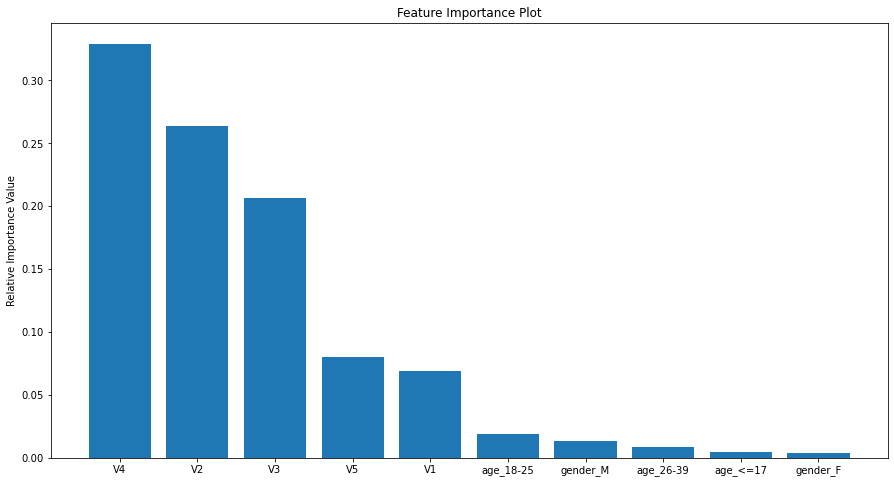

['age_18-25']

In [731]:
df_importance = pd.DataFrame({'features':x_test.columns,'value':estimator.feature_importances_})

pa_in_top_feature_importance(
    protected_attr=['gender','age'],
    top_n=6,
    df_importance=df_importance,
)

#### Shapely feature importance feature test

In [797]:
def pa_in_top_feature_importance_shap(
    protected_attr: list, 
    top_n: int, 
    model, 
    model_type: str, 
    x_train: pd.DataFrame, 
    x_test: pd.DataFrame
):
    '''
    Ouput the protected attributes that are listed in the top specified % of the features influencing the predictions
    ,using aggregated shapely values.
    
    :protected_attr: list of protected attributes
    :top_n: the top n features to be specified
    :model: trained model object
    :model_type: type of algorithim, choose from ['trees','others']
    :x_train: training data features, categorical features have to be already encoded
    :x_test: data to be used for shapely explanations, preferably eval set, categorical features have to be already encoded
    
    '''
    if model_type == 'trees':
        explainer = shap.TreeExplainer(model = model, model_output='margin')
    elif model_type == 'others':
        explainer = shap.PermutationExplainer(model = model.predict_proba, data=x_train)
    shap_values = explainer.shap_values(x_test)
    shap.summary_plot(shap_values = shap_values[1], features = x_test, max_display=20, plot_type='dot')
    
    # Take the mean of the absolute of the shapely values to get the aggretated importance for each features
    agg_shap_df=pd.DataFrame(pd.DataFrame(shap_values[1],columns=train_col).abs().mean()).sort_values(0,ascending=False)
    top_feat=list(agg_shap_df.iloc[:top_n].index)
    for i in protected_attr:
        result=[j for j in top_feat if i in j]
    
    # create a SHAP dependence plot to show the significant effect of the flagged protected attributes across the whole dataset
    for i in result:
        shap.dependence_plot(i, shap_values=shap_values[1], features=x_test,interaction_index=None)
        #shap.waterfall_plot(shap_values[:,i])
    
    return result


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


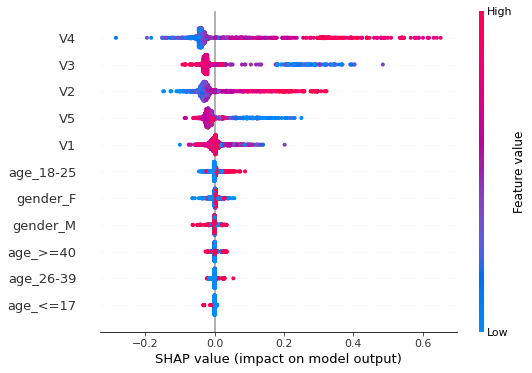

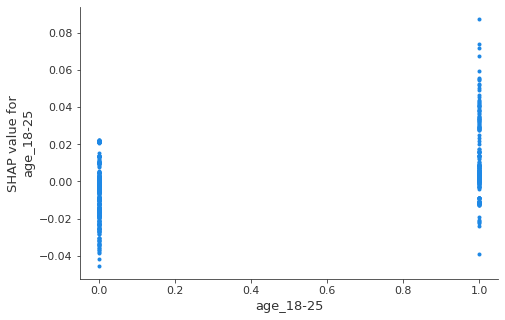

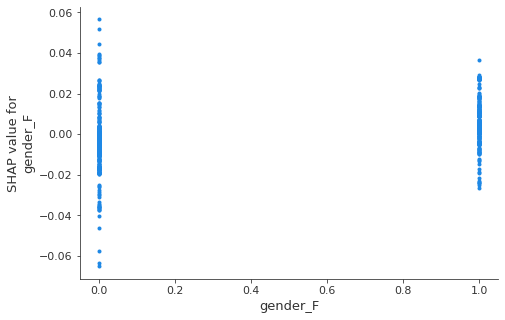

['age_18-25', 'gender_F']

In [801]:
pa_in_top_feature_importance_shap(
    protected_attr=pa,
    top_n=7,
    model=estimator,
    model_type='trees',
    x_train=x_train,
    x_test=x_test
)

#### Data shift test

In [836]:
def data_shift_test(
    protected_attr: list, 
    threshold: int,
    df_train: pd.DataFrame, 
    df_eval: pd.DataFrame, 
):
    '''
    Test if there is any shift (based on specified threshold) in the distribution of the protected feature, 
    which may impose new unfairness and require a retraining of the model, output the shifted attributes 
    
    :protected_attr: list of protected attributes
    :threshold: probability distribution threshold of an attribute, where if the difference between training data
                     distribution and evalaution distribution exceeds the threhold, the attribute will be flagged
    :df_train: training data features, protected features should not be encoded yet
    :df_eval: data to be evaluated on, protected features should not be encoded yet
    '''
    result=[]
    fig, axs = plt.subplots(1, len(pa_lst), figsize=(15, 4),)
    num=0
    for pa in protected_attr:
        df_train=df_train.sort_values(pa)
        sns.histplot(x=pa,  data=df_train, ax=axs[num],stat="probability",color='green')
        num+=1
    fig.suptitle('Distribution of protected attributes in training set')
    plt.show()
    
    fig, axs = plt.subplots(1, len(pa_lst), figsize=(15, 4),)
    num=0
    for pa in pa_lst:
        df_eval=df_eval.sort_values(pa)
        sns.histplot(x=pa,  data=df_eval, ax=axs[num],stat="probability", color='red')
        num+=1
    fig.suptitle('Distribution of protected attributes in test set')
    plt.show()
    
    for pa in protected_attr:
        train_dist = df_train.groupby(pa)[pa].apply(lambda x: x.count()/len(df_train))
        eval_dist = df_eval.groupby(pa)[pa].apply(lambda x: x.count()/len(df_eval))
        if sum(abs(train_dist - eval_dist) > threshold):
            result.append(pa)
    return result

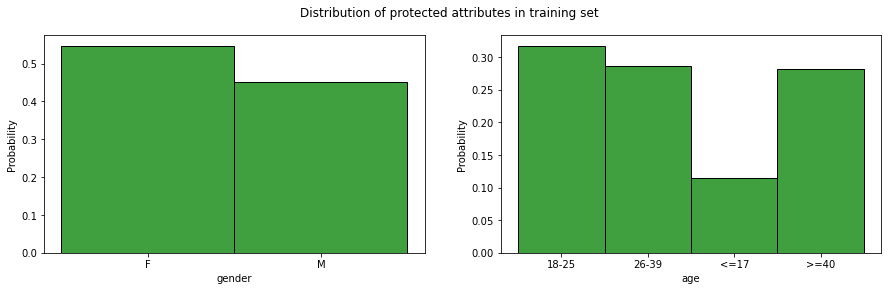

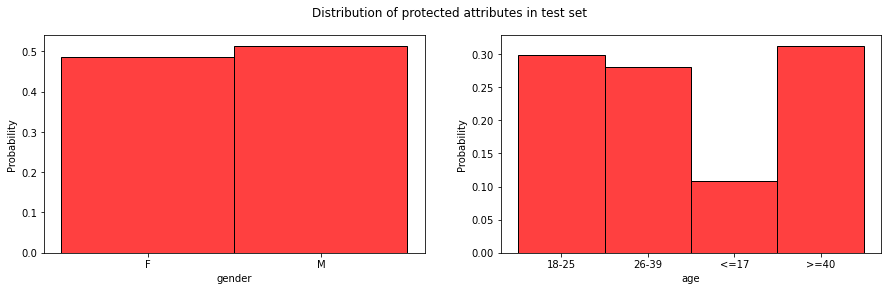

['gender']

In [844]:
train=ens.inverse_transform(x_train)
test=ens.inverse_transform(x_test)

data_shift_test(
    protected_attr = ['gender','age'],
    threshold = 0.05,
    df_train = train,
    df_eval = test 
)

#### Bias metric test

In [865]:
output

V1        V2        V3        V4        V5    age gender  truth  \
1843 -0.646569 -0.004544  0.964657  3.617302 -0.971453   >=40      F      0   
1902 -4.261404  3.854469 -5.798448  1.840096 -2.429259  18-25      M      0   
897  -0.502852  1.037547 -0.409509 -1.172476  2.482079   >=40      F      0   
1799 -1.234240 -0.359661  1.439380  0.775756  1.564515   <=17      F      0   
776  -1.739816 -0.910000  2.397355  1.761383 -2.177795   >=40      M      0   
...        ...       ...       ...       ...       ...    ...    ...    ...   
291  -0.255942  0.860395  1.576895 -0.131307  0.402481  18-25      M      0   
1983 -0.403913  1.089290  1.279471  0.015371  0.291042   >=40      F      0   
1300  1.261238  0.314645  0.529883  0.611426 -0.399191  26-39      M      0   
1332 -0.672922  0.451655  2.825452 -1.627099 -0.595283   >=40      F      0   
393   1.168718  0.038566  1.132433  2.728508 -0.499352   >=40      M      0   

      prediction  
1843           1  
1902           1  
897            0  
1799           0  
776            0  
...          ...  
291            0  
1983           0  
1300           0  
1332           0  
393            0  

[1779 rows x 9 columns]

In [933]:
def generate_bias_metrics_charts(
    protected_attr: list,
    df_test_with_output: pd.DataFrame, 
):
    '''
    Generate grouped bias metrics (false positive rates, false negative rates, predicted positive rates) charts
    and output a dictionary containing information on the maximum difference/ratio of the bias metrics 
    between any 2 groups within a protected attribute
    
    :protected_attr: list of protected attributes
    :df_test_with_output: dataframe containing protected attributes with "prediction" and "truth" column
    '''
    result={}
    for pa in protected_attr:
        fnr = {}
        fpr = {}
        sr={}
        for i in df_test_with_output[pa].unique():
    #        print(pa+' '+i)
            tmp=df_test_with_output[df_test_with_output[pa] == i]
            cm=confusion_matrix(tmp.truth, tmp.prediction)
    #         print(cm)
    #         print('\n')
    #        precision, recall, fscore, support = score(tmp.truth,tmp.prediction)
    #         print('precision: {}'.format(precision))
    #         print('recall: {}'.format(recall))
    #         print('fscore: {}'.format(fscore))
    #         print('support: {}'.format(support))
    #         print('\n')
            fnr[i] = cm[1][0]/cm[1].sum()
            fpr[i] = cm[0][1]/cm[0].sum()
            sr[i]=cm[1].sum()/cm.sum()
            result[pa+'_fnr_max_diff'] =  max(fnr.values()) - min(fnr.values())
            result[pa+'_fnr_max_ratio'] =  max(fnr.values()) / min(fnr.values())
            result[pa+'_fpr_max_diff'] =  max(fpr.values()) - min(fpr.values())
            result[pa+'_fpr_max_ratio'] =  max(fpr.values()) / min(fpr.values())
            result[pa+'_sr_max_diff'] =  max(sr.values()) - min(sr.values())
            result[pa+'_sr_max_ratio'] =  max(sr.values()) / min(sr.values())
            
        fig, axs = plt.subplots(1, 3, figsize=(18, 4), sharey=False)
        axs[0].bar(list(fnr.keys()), list(fnr.values()))
        axs[0].set_title('False Negative Rates')
        axs[1].bar(list(fpr.keys()), list(fpr.values()))
        axs[1].set_title('False Positive Rates')
        axs[2].bar(list(sr.keys()), list(sr.values()))
        axs[2].set_title('Predicted Positive Rates')
        fig.suptitle('Attribute: '+ pa)
        plt.show()
    return result
        
    
    

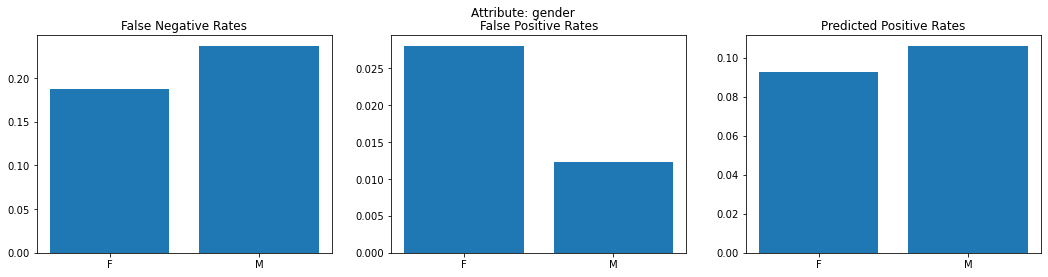

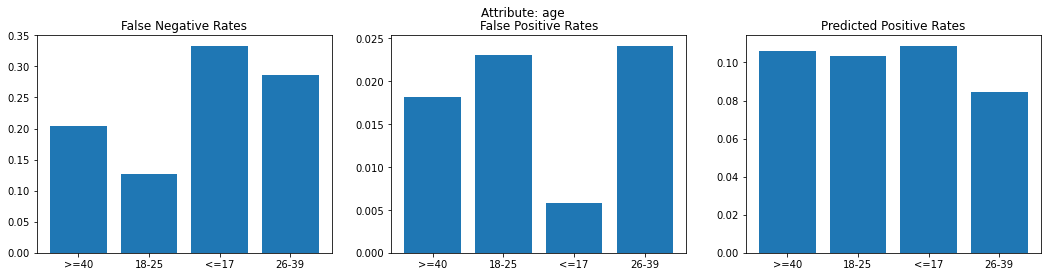

In [935]:
metric_dict=generate_bias_metrics_charts(
                protected_attr = ['gender','age'],
                df_test_with_output = output
            )

In [936]:
metric_dict

{'gender_fnr_max_diff': 0.04961340206185566,
 'gender_fnr_max_ratio': 1.2646048109965635,
 'gender_fpr_max_diff': 0.015785575626223014,
 'gender_fpr_max_ratio': 2.2896815286624204,
 'gender_sr_max_diff': 0.013641365527883531,
 'gender_sr_max_ratio': 1.1474972647702406,
 'age_fnr_max_diff': 0.20606060606060606,
 'age_fnr_max_ratio': 2.619047619047619,
 'age_fpr_max_diff': 0.018308853529171765,
 'age_fpr_max_ratio': 4.149122807017544,
 'age_sr_max_diff': 0.024470940757850057,
 'age_sr_max_ratio': 1.290155440414508}

In [951]:
def bias_metrics_test(
    attr: str, 
    metric: str,
    method: str,
    threshold: int,
):
    '''
    Check if the maximum difference/ratio of the specified bias metric of any 2 groups within a specified protected attribute
    exceeds the threshold specified
    
    :attr: protected attribute specified
    :metric: type of bias metric for the test, choose from ('fpr', 'fnr', 'sr'), 
             'fpr' - false positive rate, 'fnr' - false negative rate, 'sr': selection rate
    :method: type of method for the test, choose from ('diff', 'ratio')
    :threshold: threshold which if the max difference of false positive, false negative, negative 
    '''
    metric_dict = generate_bias_metrics_charts(
                      protected_attr = ['gender','age'],
                      df_test_with_output = output
                  )
    return metric_dict[attr+'_'+metric+'_max_'+method] > threshold
    

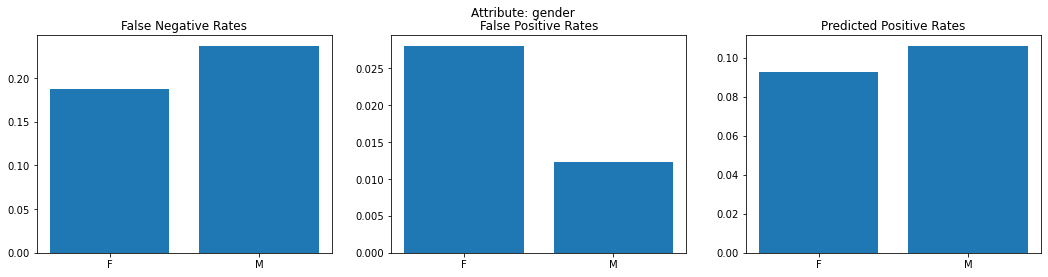

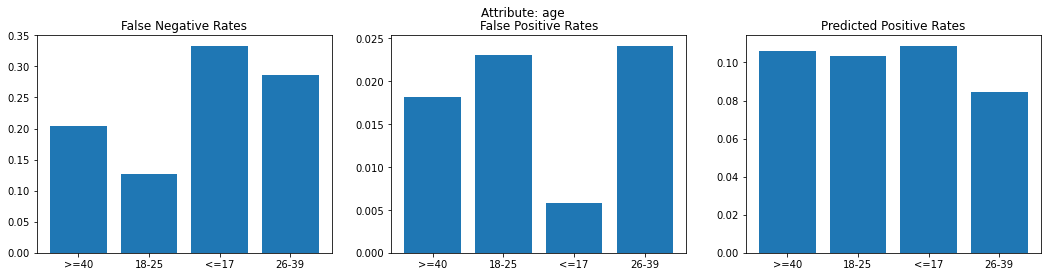

False

In [952]:
bias_metrics_test(
    attr='gender',
    metric='sr',
    method='ratio',
    threshold=1.5,
)

#### Perturbation by shuffling the values of the protected attribute

gender F
[[757  12]
 [ 26  70]]


precision: [0.96679438 0.85365854]
recall: [0.98439532 0.72916667]
fscore: [0.97551546 0.78651685]
support: [769  96]


gender M
[[811  22]
 [ 17  64]]


precision: [0.9794686  0.74418605]
recall: [0.97358944 0.79012346]
fscore: [0.97652017 0.76646707]
support: [833  81]


age >=40
[[484  15]
 [ 15  42]]


precision: [0.96993988 0.73684211]
recall: [0.96993988 0.73684211]
fscore: [0.96993988 0.73684211]
support: [499  57]


age 18-25
[[474   9]
 [ 11  38]]


precision: [0.97731959 0.80851064]
recall: [0.98136646 0.7755102 ]
fscore: [0.97933884 0.79166667]
support: [483  49]


age <=17
[[169   2]
 [  4  18]]


precision: [0.97687861 0.9       ]
recall: [0.98830409 0.81818182]
fscore: [0.98255814 0.85714286]
support: [171  22]


age 26-39
[[439  10]
 [ 11  38]]


precision: [0.97555556 0.79166667]
recall: [0.97772829 0.7755102 ]
fscore: [0.97664071 0.78350515]
support: [449  49]




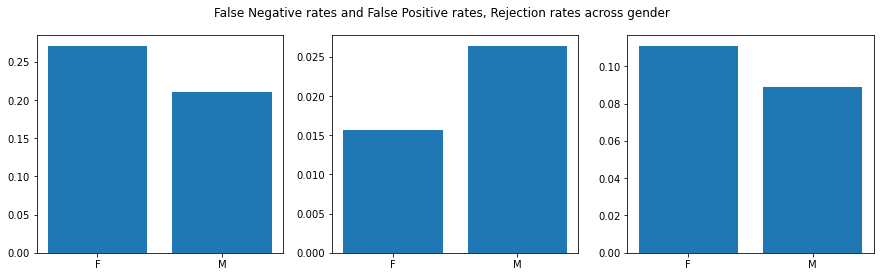

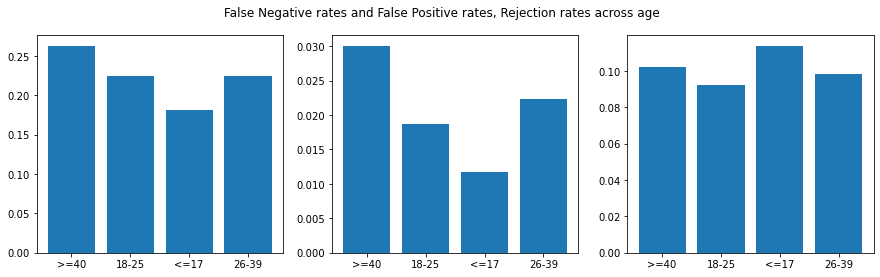

In [535]:
test=ens.inverse_transform(x_test)

for pa in ['gender','age']:
    fnr = {}
    fpr = {}
    rr={}
    test_perturb=test.copy()
    test_perturb[pa]=np.random.permutation(test_perturb[pa].values)
    test_perturb=ens.transform(test_perturb)
    y_pred = estimator.predict(test_perturb)
    output_perturb=ens.inverse_transform(test_perturb)
    output_perturb['truth']=y_test
    output_perturb['prediction']=y_pred
    for i in output[pa].unique():
        print(pa+' '+i)
        tmp=output_perturb[output_perturb[pa] == i]
        cm=confusion_matrix(tmp.truth, tmp.prediction)
        print(cm)
        print('\n')
        precision, recall, fscore, support = score(tmp.truth,tmp.prediction)
        print('precision: {}'.format(precision))
        print('recall: {}'.format(recall))
        print('fscore: {}'.format(fscore))
        print('support: {}'.format(support))
        print('\n')
        fnr[i] = 1-recall[1]
        fpr[i] = 1-recall[0]
        rr[i]=cm[1].sum()/cm.sum()
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=False)
    axs[0].bar(list(fnr.keys()), list(fnr.values()))
    axs[1].bar(list(fpr.keys()), list(fpr.values()))
    axs[2].bar(list(rr.keys()), list(rr.values()))
    fig.suptitle('False Negative rates and False Positive rates, Rejection rates across '+ pa)
        

#### Lime model, single observation explaination

In [489]:
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(x_train),
    feature_names=x_train.columns,
    class_names=y_train.unique(),
    mode='classification'
)

exp = explainer.explain_instance(
    data_row=x_test.iloc[0], 
    predict_fn=estimator.predict_proba
)

exp.show_in_notebook(show_table=True)